[Reference](https://medium.com/codex/seo-analysis-with-graph-neural-network-model-the-structure-of-a-website-as-a-graph-488e1bb5b9e2)

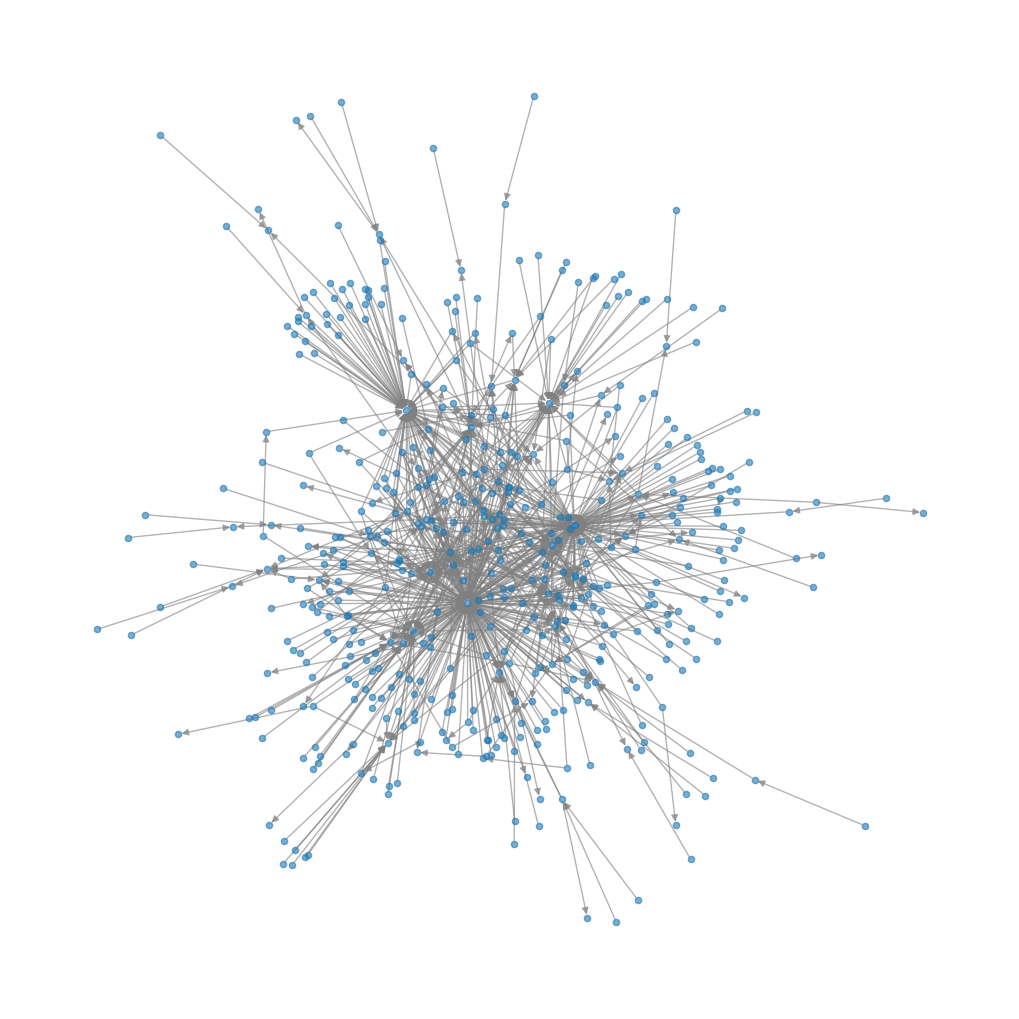

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.special import expit  # logistic function
import random
import matplotlib.pyplot as plt

# Initial settings
np.random.seed(42)
random.seed(42)
n_nodes = 500

# === 1. Graph Creation ===
G_raw = nx.scale_free_graph(n=n_nodes, seed=42)
G_raw = nx.DiGraph(G_raw)  # grafo orientato
G_raw.remove_edges_from(nx.selfloop_edges(G_raw))  # remove self-loop
G = nx.DiGraph()
G.add_edges_from(set(G_raw.edges()))  # convert to simple graph

# Visualization of the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_size=20, edge_color='gray', alpha=0.6)
plt.show()

In [2]:
# === 2. ADDING ATTRIBUTES TO NODES ===
page_types = ['home', 'blog', 'landing', 'product', 'contacts']
page_type_dist = [0.01, 0.4, 0.2, 0.3, 0.09]  # non-unform distribution
pagerank_dict = nx.pagerank(G)
pagerank_vals = np.array(list(pagerank_dict.values()))
pagerank_scaled = StandardScaler().fit_transform(pagerank_vals.reshape(-1, 1)).flatten()

home_node = max(pagerank_dict, key=pagerank_dict.get)
depth_dict = nx.single_source_shortest_path_length(G.reverse(), home_node)  # distance from homepage

for i, node in enumerate(G.nodes()):
    depth = depth_dict.get(node, None)
    G.nodes[node]['page_type'] = np.random.choice(page_types, p=page_type_dist)
    G.nodes[node]['avg_time'] = np.random.uniform(10, 240)
    G.nodes[node]['pagerank'] = pagerank_scaled[i]
    G.nodes[node]['word_count'] = int(np.clip(np.random.normal(800, 400), 100, 2000))
    # Sostituisce np.inf con -1 se il nodo non è raggiungibile
    G.nodes[node]['depth'] = depth if depth is not None else -1

In [3]:
# === 3. ADDING ARC ATTRIBUTES ===
for u, v in G.edges():
    G[u][v]['link_type'] = np.random.choice(['internal', 'external'], p=[0.9, 0.1])
    G[u][v]['dom_position'] = np.random.choice(['header', 'body', 'footer'], p=[0.15, 0.7, 0.15])
    G[u][v]['anchor_keyword'] = np.random.choice([0, 1], p=[0.7, 0.3])
    G[u][v]['anchor_length'] = np.random.randint(1, 8)

In [4]:
# === 4. CALCULATION OF TARGET (is_strategic) ===
def logistic(x): return expit(x)

edges_data = []
for u, v, attrs in G.edges(data=True):
    dom_weight = {'header': 1.0, 'body': 0.5, 'footer': 0.2}[attrs['dom_position']]
    keyword = attrs['anchor_keyword']
    pagerank_src = G.nodes[u]['pagerank']
    page_type_dst = G.nodes[v]['page_type']
    dst_weight = 1 if page_type_dst in ['landing', 'product'] else 0

    score = 2.5 * dom_weight + 1.5 * keyword + 1.0 * pagerank_src + 1.0 * dst_weight
    prob = logistic(score)
    is_strategic = np.random.binomial(1, prob)

    edges_data.append({
        'source': u,
        'target': v,
        'is_strategic': is_strategic,
        **attrs,
        'pagerank_src': pagerank_src,
        'page_type_dst': page_type_dst,
        'dom_weight': dom_weight
    })

df_edges = pd.DataFrame(edges_data)

print("Example of strategic simulated links:")
print(df_edges.sample(5))

Example of strategic simulated links:
     source  target  is_strategic link_type dom_position  anchor_keyword  \
96        5     184             1  internal         body               0   
39       87       9             0  external       footer               0   
634     391      53             1  internal         body               1   
734     318       0             1  internal       footer               0   
791     218       1             1  internal         body               0   

     anchor_length  pagerank_src page_type_dst  dom_weight  
96               3      0.905362          blog         0.5  
39               6     -0.131457          blog         0.2  
634              1     -0.163020       product         0.5  
734              6     -0.163020          blog         0.2  
791              6     -0.163020       product         0.5  


In [6]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

node_df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
categorical = pd.get_dummies(node_df['page_type'])
numerical = node_df[['avg_time', 'pagerank', 'word_count', 'depth']]
X_nodes = torch.tensor(np.hstack([numerical.values, categorical.values]), dtype=torch.float)

edge_index = torch.tensor(df_edges[['source', 'target']].values.T, dtype=torch.long)
edge_label = torch.tensor(df_edges['is_strategic'].values, dtype=torch.float)

edges_idx = np.arange(edge_index.shape[1])
train_idx, test_idx = train_test_split(edges_idx, test_size=0.3, stratify=edge_label, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=edge_label[test_idx], random_state=42)

train_idx = torch.tensor(train_idx, dtype=torch.long)
val_idx = torch.tensor(val_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

data = Data(x=X_nodes, edge_index=edge_index)

In [8]:
# === Model GCN + MLP for edge classification ===
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class EdgeClassifier(torch.nn.Module):
    def __init__(self, encoder, hidden_channels):
        super().__init__()
        self.encoder = encoder
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_pairs):
        z = self.encoder(x, edge_index)
        src, dst = edge_pairs
        edge_feat = torch.cat([z[src], z[dst]], dim=1)
        return self.classifier(edge_feat).squeeze()

In [9]:
# === Model GCN + MLP for edge classification ===
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

class EdgeClassifier(torch.nn.Module):
    def __init__(self, encoder, hidden_channels):
        super().__init__()
        self.encoder = encoder
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1)
        )

    def forward(self, x, edge_index, edge_pairs):
        z = self.encoder(x, edge_index)
        src, dst = edge_pairs
        edge_feat = torch.cat([z[src], z[dst]], dim=1)
        return self.classifier(edge_feat).squeeze()

# === Initialization ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeClassifier(GCNEncoder(in_channels=X_nodes.shape[1], hidden_channels=32), hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

data = data.to(device)
edge_label = edge_label.to(device)
train_idx = train_idx.to(device)
val_idx = val_idx.to(device)
test_idx = test_idx.to(device)

# === Training loop ===
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    pred = model(data.x, data.edge_index, data.edge_index[:, train_idx])
    loss = loss_fn(pred, edge_label[train_idx])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(data.x, data.edge_index, data.edge_index[:, val_idx])
        val_loss = loss_fn(val_pred, edge_label[val_idx])
        val_acc = ((val_pred > 0).float() == edge_label[val_idx]).float().mean()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

Epoch 010, Train Loss: 72.2168, Val Loss: 4.4970, Val Acc: 0.8438
Epoch 020, Train Loss: 9.4007, Val Loss: 11.5056, Val Acc: 0.8516
Epoch 030, Train Loss: 6.4561, Val Loss: 6.3937, Val Acc: 0.8516
Epoch 040, Train Loss: 2.1031, Val Loss: 0.9223, Val Acc: 0.7344
Epoch 050, Train Loss: 1.6799, Val Loss: 2.9763, Val Acc: 0.2812
Epoch 060, Train Loss: 1.6779, Val Loss: 0.6982, Val Acc: 0.7578
Epoch 070, Train Loss: 0.7296, Val Loss: 0.8548, Val Acc: 0.8516
Epoch 080, Train Loss: 0.9946, Val Loss: 1.6466, Val Acc: 0.8516
Epoch 090, Train Loss: 2.0659, Val Loss: 1.6100, Val Acc: 0.8516
Epoch 100, Train Loss: 1.0940, Val Loss: 1.0579, Val Acc: 0.8516


In [11]:
# === Final test ===
model.eval()
with torch.no_grad():
    test_pred = model(data.x, data.edge_index, data.edge_index[:, test_idx])
    test_acc = ((test_pred > 0).float() == edge_label[test_idx]).float().mean()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8516


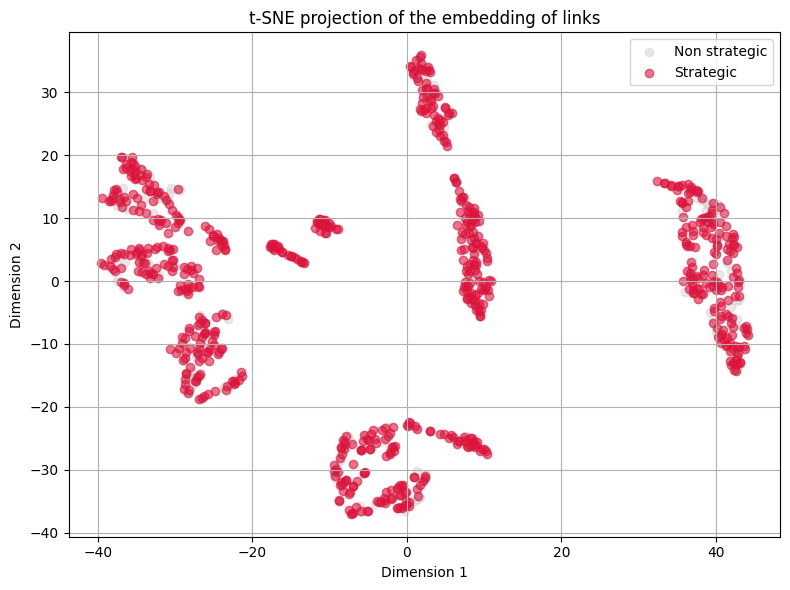

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = model.encoder(data.x, data.edge_index).cpu()

# Extract embedding of the arcs
edge_src = data.edge_index[0].cpu().numpy()
edge_dst = data.edge_index[1].cpu().numpy()
edge_emb = torch.cat([z[edge_src], z[edge_dst]], dim=1).numpy()
labels = edge_label.cpu().numpy()

# Dimensional reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(edge_emb)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[labels == 0, 0], emb_2d[labels == 0, 1], c='lightgray', label='Non strategic', alpha=0.5)
plt.scatter(emb_2d[labels == 1, 0], emb_2d[labels == 1, 1], c='crimson', label='Strategic', alpha=0.6)
plt.legend()
plt.title("t-SNE projection of the embedding of links")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
import matplotlib.pyplot as plt

# === Wrapper compatible with Explainer ===
class EdgeExplainerWrapper(torch.nn.Module):
    def __init__(self, model, edge_idx):
        super().__init__()
        self.model = model
        self.edge_idx = edge_idx  # singolo indice dell’arco

    def forward(self, x, edge_index):
        edge_pair = edge_index[:, self.edge_idx].view(2, 1)
        return self.model(x, edge_index, edge_pair)

# === Prepare  the data ===
x_cpu = data.x.cpu()
edge_index_cpu = data.edge_index.cpu()

# === Select a strategic link to explain===
strategic_edges = df_edges[df_edges['is_strategic'] == 1].reset_index(drop=True)
link_idx = strategic_edges.index[0]  # ad es. il primo arco strategico
source_id = strategic_edges.loc[link_idx, 'source']
target_id = strategic_edges.loc[link_idx, 'target']
print(f"Explanation for strategic link: {source_id} → {target_id} (index {link_idx})")

# === Create the model wrapper ===
wrapped_model = EdgeExplainerWrapper(model, edge_idx=link_idx)

# === Define the Explainer ===
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='edge',
        return_type='raw'
    )
)

# === Obtain the explanation ===
explanation = explainer(x=x_cpu, edge_index=edge_index_cpu)

# === Analyze masks ===
edge_mask = explanation.get('edge_mask')
node_mask = explanation.get('node_mask')

# === Visualize top-k important arcs ===
if edge_mask is not None:
    topk = torch.topk(edge_mask, k=5)
    print("Top 5 most influential arc:")
    for idx, score in zip(topk.indices, topk.values):
        src, tgt = edge_index_cpu[:, idx]
        print(f"{src.item()} → {tgt.item()} — weight: {score.item():.4f}")

Explanation for strategic link: 58 → 1 (index 0)
Top 5 most influential arc:
387 → 1 — weight: 0.5724
79 → 1 — weight: 0.5063
119 → 1 — weight: 0.4990
62 → 1 — weight: 0.4898
39 → 1 — weight: 0.4672


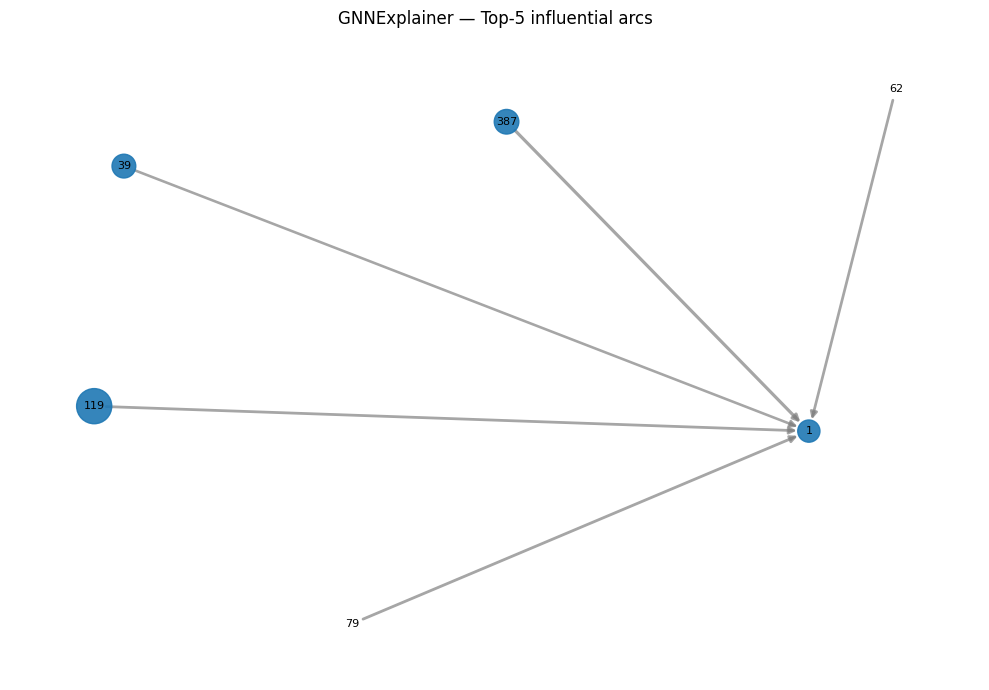

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import numpy as np

# === PARAMETER: number of top arcs to visualize ===
k = 5  # you can modificy it (es. 20, 50, ecc.)

# === Extract top-k arcs from edge_mask ===
topk = torch.topk(edge_mask, k=k)
top_edge_indices = topk.indices.cpu().numpy()
top_edge_weights = topk.values.cpu().numpy()

# === Create filtered graph with top-k arcs ===
G_top = nx.DiGraph()

for idx, weight in zip(top_edge_indices, top_edge_weights):
    u = edge_index_cpu[0, idx].item()
    v = edge_index_cpu[1, idx].item()
    G_top.add_edge(u, v, weight=weight)

# === Add weights to the nodes===
node_mask_np = node_mask.detach().cpu().numpy().flatten()  # <-- fix qui

for node in G_top.nodes():
    raw_value = node_mask_np[node]
    safe_value = float(np.nan_to_num(raw_value, nan=0.0, posinf=0.0, neginf=0.0))
    G_top.nodes[node]['weight'] = safe_value

# === Layout and grafic attributes ===
pos = nx.spring_layout(G_top, seed=42)
nodelist = list(G_top.nodes())
node_sizes = [G_top.nodes[n].get('weight', 0.0) * 1000 for n in nodelist]

edgelist = list(G_top.edges())
edge_widths = [G_top[u][v]['weight'] * 4 for u, v in edgelist]
edge_colors = ['red' if (u == source_id and v == target_id) else 'gray' for u, v in edgelist]

# === Visualization ===
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(G_top, pos, nodelist=nodelist, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G_top, pos, edgelist=edgelist, width=edge_widths, edge_color=edge_colors, alpha=0.7)
nx.draw_networkx_labels(G_top, pos, font_size=8)
plt.title(f"GNNExplainer — Top-{k} influential arcs")
plt.axis("off")
plt.tight_layout()
plt.show()